In [1]:
import argparse
import os
import numpy as np
import time
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

from dataset import *
from model import *
from utils import *

class_num = 4 #cat dog person background

num_epochs = 30
batch_size = 32


boxs_default = default_box_generator([10,5,3,1], [0.2,0.4,0.6,0.8], [0.1,0.3,0.5,0.7])


#Create network
network = SSD(class_num)
network.cuda()
cudnn.benchmark = True

/home/mka219/.conda/envs/image_segmentation/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load = True
if load:
  print('loading model')
  network.load_state_dict(torch.load('network_3feb.pth'))


loading model


In [3]:

dataset = COCO("data/train/images/", "data/train/annotations/", class_num, boxs_default, train = "True", image_size=320)
#dataset_test = COCO("data/train/images/", "data/train/annotations/", class_num, boxs_default, train = False, image_size=320)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
optimizer = optim.Adam(network.parameters(), lr = 1e-4)


Training


In [4]:
len(dataloader)

180

[0] time: 43.924704 train loss: 1.081101


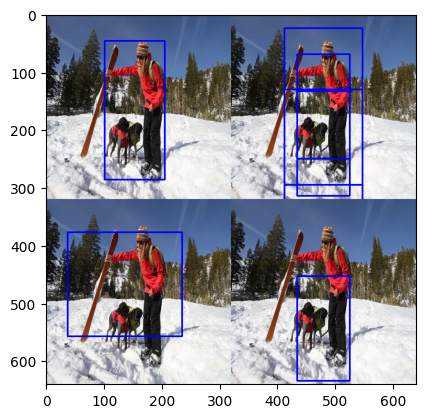

[1] time: 88.805704 train loss: 1.082131


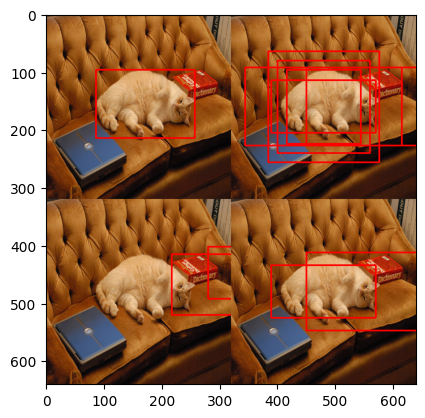

[2] time: 134.309458 train loss: 1.081879


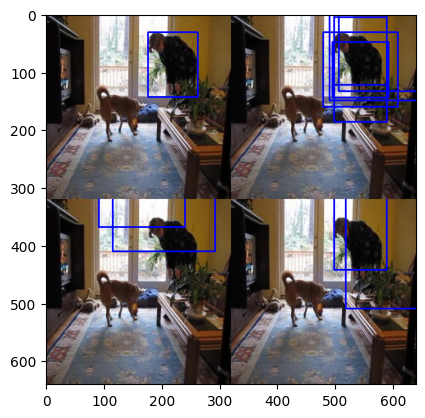

[3] time: 180.300578 train loss: 1.081151


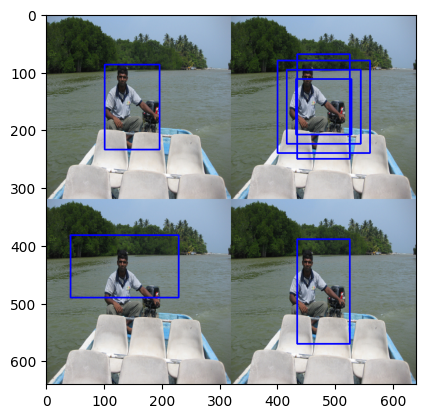

[4] time: 226.436513 train loss: 1.079902


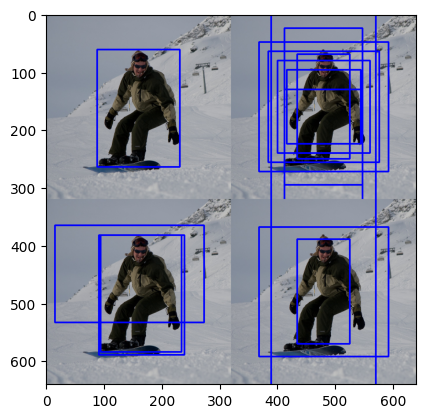

[5] time: 272.616960 train loss: 1.078685


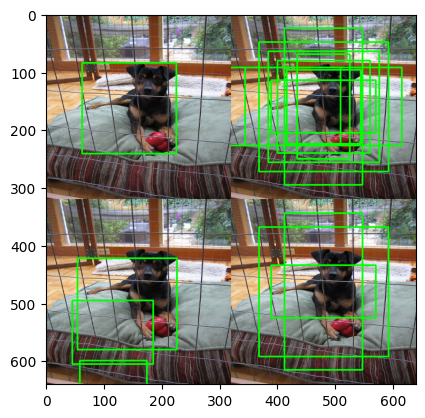

In [6]:

#feel free to try other optimizers and parameters.

start_time = time.time()

for epoch in range(num_epochs):
    #TRAINING
    network.train()

    avg_loss = 0
    avg_count = 0
    for i, data in enumerate(dataloader, 0):
        images_, ann_box_, ann_confidence_ = data
        images = images_.cuda()
        img = images_[0].numpy()
        #img = np.transpose(img, (1,2,0))
        #cv2.imshow(" check ",np.transpose(img, (1,2,0)))
        #cv2.waitKey(1)
        ann_box = ann_box_.cuda()
        ann_confidence = ann_confidence_.cuda()

        optimizer.zero_grad()
        #print(" before model", time.time()-start_time)
        pred_confidence, pred_box = network(images)
        #print("after model", time.time()-start_time)
        loss_net = SSD_loss(pred_confidence, pred_box, ann_confidence, ann_box)
        loss_net.backward()
        optimizer.step()
        
        avg_loss += loss_net.data
        avg_count += 1
        #break
        #if i==10:
            #break

    print('[%d] time: %f train loss: %f' % (epoch, time.time()-start_time, avg_loss/avg_count))
    
    #visualize
    pred_confidence_ = pred_confidence[0].detach().cpu().numpy()
    pred_box_ = pred_box[0].detach().cpu().numpy()
    pred_box_, pred_confidence_, ogn_pred_box = non_maximum_suppression(pred_box_, pred_confidence_, boxs_default)
    visualize_pred("train", pred_confidence_, pred_box_, ann_confidence_[0].numpy(), ann_box_[0].numpy(), images_[0].numpy(), boxs_default, ogn_pred_box)
    
    
    #VALIDATION
    network.eval()
    
    #optional: compute F1
    #F1score = 2*precision*recall/np.maximum(precision+recall,1e-8)
    #print(F1score)
    
    #save weights
    if epoch%10==9:
        #save last network
        print('saving net...')
        torch.save(network.state_dict(), 'network_3feb.pth')
    #break




In [2]:
dataset_test = COCO("data/train/images/", "data/train/annotations/", class_num, boxs_default, train = False, image_size=320)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

In [3]:
network.load_state_dict(torch.load('network_v3.pth'))
network.eval()


SSD(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [2]:
dataframes_list = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
for i, data in enumerate(dataloader_test, 0):
    images_, ann_box_, ann_confidence_,val_gt_info = data
    images = images_.cuda()
    ann_box = ann_box_.cuda()
    ann_confidence = ann_confidence_.cuda()
    print(images.shape)
    pred_confidence, pred_box = network(images)

    pred_confidence_ = pred_confidence[0].detach().cpu().numpy()
    pred_box_ = pred_box[0].detach().cpu().numpy()
    
    pred_confidence_,pred_box_ = non_maximum_suppression(pred_confidence_,pred_box_,boxs_default)
    
    #TODO: save predicted bounding boxes and classes to a txt file.
    #you will need to submit those files for grading this assignment
    
    #visualize_pred("test", pred_confidence_, pred_box_, ann_confidence_[0].numpy(), ann_box_[0].numpy(), images_[0].numpy(), boxs_default)
    f_val_gt_info = []
    for j in val_gt_info[0]:
        f_val_gt_info.append(j.numpy()[0])
    map_output = generate_mAP(pred_confidence_, pred_box_, boxs_default, [f_val_gt_info])
    for l in range(len(map_output)):
        dataframes_list[i]= pd.concat((dataframes_list[i], map_output[i]))
    

NameError: name 'pd' is not defined

In [7]:
for j in val_gt_info[0]:
    print(j.numpy()[0])

1.0
406.3
197.82
171.64
167.76
480
640


In [7]:
for i in val_gt_info[0]:
    print(i)

KeyError: 0

In [18]:
val_gt_info[0][0].detach().cpu().numpy()

array([1.])

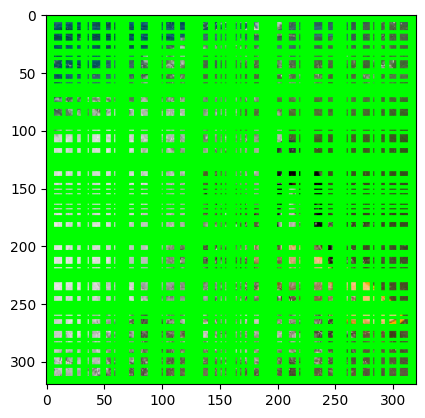

In [4]:
img = images_[0].numpy()
img = img*255
img = np.transpose(img, (1,2,0)).astype(np.uint8)
img = np.ascontiguousarray(img, dtype=np.uint8)
count = 0

#img = np.random.rand(320,320,3)
for i in range(len(boxs_default)):
    #if i>131:
    #print("gx, gy, gw, gh", gx, "  ", gy, "  ", gw, "  ", gh, "  ")
    start_point = ( int( (boxs_default[i][0]-(boxs_default[i][2]/2))*320 ), int( (boxs_default[i][1]-(boxs_default[i][3]/2))*320 ) )
    end_point = ( int( (boxs_default[i][0]+(boxs_default[i][2]/2))*320 ), int( (boxs_default[i][1]+(boxs_default[i][3]/2))*320 ) )

    thickness = 2
    cv2.rectangle(img, start_point, end_point, (0,255,0), thickness)
    #count = count+1
    #if count==4:
    #    break
plt.imshow(img)

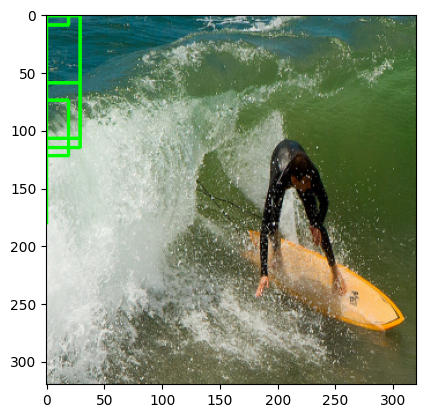

In [5]:
img = images_[0].numpy()
img = img*255
img = np.transpose(img, (1,2,0)).astype(np.uint8)
img = np.ascontiguousarray(img, dtype=np.uint8)

ann_box = ann_box_[0].numpy()
count = 0

#img = np.random.rand(320,320,3)
for i in range(len(ann_box)):
    #if i>131:
    #print("gx, gy, gw, gh", gx, "  ", gy, "  ", gw, "  ", gh, "  ")
    start_point = ( int( (ann_box[i][0]-(ann_box[i][2]/2))*320 ), int( (ann_box[i][1]-(ann_box[i][3]/2))*320 ) )
    end_point = ( int( (ann_box[i][0]+(ann_box[i][2]/2))*320 ), int( (ann_box[i][1]+(boxs_default[i][3]/2))*320 ) )

    thickness = 2
    cv2.rectangle(img, start_point, end_point, (0,255,0), thickness)
    #count = count+1
    #if count==4:
    #    break
plt.imshow(img)

In [6]:
ann_box

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [7]:
boxs_default = default_box_generator([10,5,3,1], [0.2,0.4,0.6,0.8], [0.1,0.3,0.5,0.7])

In [8]:
img = np.random.rand(320,320,3)
count = 0
for i in range(len(boxs_default)):
    if i>131:
    #print("gx, gy, gw, gh", gx, "  ", gy, "  ", gw, "  ", gh, "  ")
        start_point = ( int( (boxs_default[i][0]-(boxs_default[i][2]/2))*320 ), int( (boxs_default[i][1]-(boxs_default[i][3]/2))*320 ) )
        end_point = ( int( (boxs_default[i][0]+(boxs_default[i][2]/2))*320 ), int( (boxs_default[i][1]+(boxs_default[i][3]/2))*320 ) )

        thickness = 2
        cv2.rectangle(img, start_point, end_point, (0,255,0), thickness)
        count = count+1
    if count==4:
        break
    max_position

NameError: name 'max_position' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


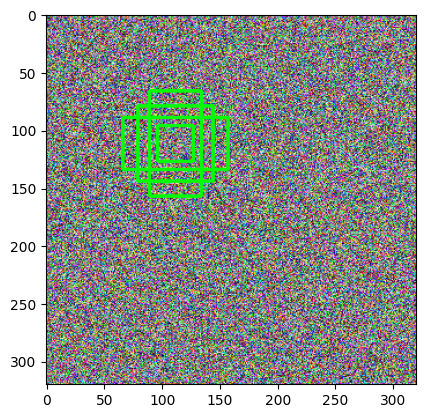

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
import cv2
cv2.imshow(" [[gt_box,gt_dft],[pd_box,pd_dft]]",img)
cv2.waitKey(1)

-1

: 

In [ ]:
def iou(boxs_default, x_min,y_min,x_max,y_max):
    #input:
    #boxes -- [num_of_boxes, 8], a list of boxes stored as [box_1,box_2, ...], where box_1 = [x1_center, y1_center, width, height, x1_min, y1_min, x1_max, y1_max].
    #x_min,y_min,x_max,y_max -- another box (box_r)
    
    #output:
    #ious between the "boxes" and the "another box": [iou(box_1,box_r), iou(box_2,box_r), ...], shape = [num_of_boxes]
    
    inter = np.maximum(np.minimum(boxs_default[:,6],x_max)-np.maximum(boxs_default[:,4],x_min),0)*np.maximum(np.minimum(boxs_default[:,7],y_max)-np.maximum(boxs_default[:,5],y_min),0)
    area_a = (boxs_default[:,6]-boxs_default[:,4])*(boxs_default[:,7]-boxs_default[:,5])
    area_b = (x_max-x_min)*(y_max-y_min)
    union = area_a + area_b - inter
    return inter/np.maximum(union,1e-8)


In [ ]:
def match(ann_box,ann_confidence,boxs_default,threshold,class_id,x_min,y_min,x_max,y_max, line, org_width, org_height):
    #input:
    #ann_box                 -- [num_of_boxes,4], ground truth bounding boxes to be updated
    #ann_confidence          -- [num_of_boxes,number_of_classes], ground truth class labels to be updated
    #boxs_default            -- [num_of_boxes,8], default bounding boxes
    #threshold               -- if a default bounding box and the ground truth bounding box have iou>threshold, then this default bounding box will be used as an anchor
    #cat_id                  -- class id, 0-cat, 1-dog, 2-person
    #x_min,y_min,x_max,y_max -- bounding box
    gx = line[1]/org_width
    gy = line[2]/org_height
    gw = line[3]/org_width
    gh = line[4]/org_height
    gx = gx+(gw/2)
    gy = gy+(gh/2)

    #gx = gx+(gw/2)
    #gy = gy+(gh/2)
    print("gx gy, gw, gh", gx, gy, gw, gh)
    #compute iou between the default bounding boxes and the ground truth bounding box
    ious = iou(boxs_default, x_min,y_min,x_max,y_max)
    assign_label = 0 
    ious_true = ious>threshold
    print(np.where(ious_true==True))
    #TODO:
    for i in range(len(ious_true)):
        if ious_true[i]:
            assign_label=1
            if class_id==0:
                ann_confidence[i][1] = 0
                ann_confidence[i][2] = 0
                ann_confidence[i][3] = 0
                ann_confidence[i][0] = 1
            elif class_id==1:
                ann_confidence[i][0] = 0
                ann_confidence[i][2] = 0
                ann_confidence[i][3] = 0
                ann_confidence[i][1] = 1
            elif class_id==2:
                ann_confidence[i][0] = 0
                ann_confidence[i][1] = 0
                ann_confidence[i][3] = 0
                ann_confidence[i][2] = 1
            
            box = boxs_default[i]
            px = box[0]
            py = box[1]
            pw = box[2]
            ph = box[3]
            ann_box[i][0] =  ( gx-px ) / pw #tx
            ann_box[i][1] =  ( gy-py ) / ph #ty
            ann_box[i][2] =  math.log(gw/pw) #tw
            ann_box[i][3] =  math.log(gh/ph) #th
            
    #update ann_box and ann_confidence, with respect to the ious and the default bounding boxes.
    #if a default bounding box and the ground truth bounding box have iou>threshold, then we will say this default bounding box is carrying an object.
    #this default bounding box will be used to update the corresponding entry in ann_box and ann_confidence
    if x_max>0.9 and i==0:
                x_max = 0.9
    #TODO:
    #make sure at least one default bounding box is used
    #update ann_box and ann_confidence (do the same thing as above)
    if assign_label==0:
        marea_ind = np.argmax(ious)
        ann_confidence[marea_ind][3] = 0
        ann_confidence[marea_ind][0] = 1
        box = boxs_default[marea_ind]
        px = box[0]
        py = box[1]
        pw = box[2]
        ph = box[3]
        ann_box[marea_ind][0] =  ( gx-px ) / pw #tx
        ann_box[marea_ind][1] =  ( gy-py ) / ph #ty
        ann_box[marea_ind][2] =  math.log(gw/pw) #tw
        ann_box[marea_ind][3] =  math.log(gh/ph) #th
    
    return ann_box, ann_confidence



In [ ]:
image = transforms.ToTensor()(Image.open("/home/mka219/sfuhome/T2- A1/A1/workspace/data/train/images/00003.jpg"))
t_image = image.numpy()
org_height = image.shape[1]
org_width = image.shape[2]
print(org_height)
print(org_width)
resize_t = transforms.Resize((320,320))
image = resize_t(image)
ann_text_processed=[]
threshold = 0.5
ann_text = open("/home/mka219/sfuhome/T2- A1/A1/workspace/data/train/annotations/00003.txt").readlines()
ann_box = np.zeros([540,4], np.float32) #bounding boxes
ann_confidence = np.zeros([540,4], np.float32)
for line in ann_text:
    ann_text_processed.append( [float(i) for i in line.rstrip().split(' ')] )

for line in ann_text_processed:
    class_id = line[0]
    print(line)
    gx = line[1]/ org_width
    gy = line[2]/ org_height
    gw = line[3]/ org_width
    gh = line[4]/ org_height
     
    x_min = gx 
    y_min = gy 
    x_max = gx+gw 
    y_max = gy+gh 
    
    ann_box, ann_confidence = match(ann_box, ann_confidence, boxs_default, threshold, class_id, x_min, y_min, x_max, y_max, line, org_width, org_height)

480
640
[2.0, 254.05, 130.27, 151.36, 298.38]
gx gy, gw, gh 0.515203125 0.5822083333333333 0.23650000000000002 0.621625
(array([451, 471]),)


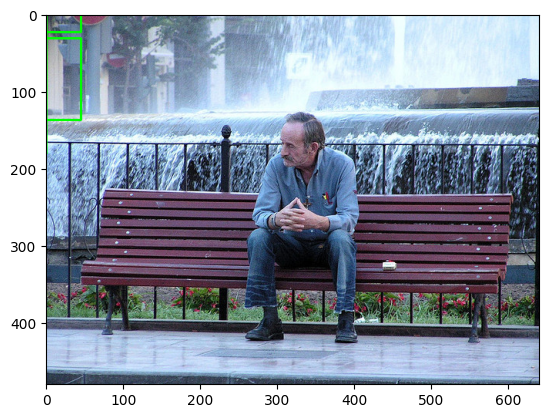

In [ ]:
img = t_image
img = img*255
img = np.transpose(img, (1,2,0)).astype(np.uint8)
img = np.ascontiguousarray(img, dtype=np.uint8)

#ann_box = ann_box_[0].numpy()
count = 0

#img = np.random.rand(320,320,3)
for i in range(len(ann_box)):
    #if i>131:
    #print("gx, gy, gw, gh", gx, "  ", gy, "  ", gw, "  ", gh, "  ")
    start_point = ( int( (ann_box[i][0]-(ann_box[i][2]/2))*320 ), int( (ann_box[i][1]-(ann_box[i][3]/2))*320 ) )
    end_point = ( int( (ann_box[i][0]+(ann_box[i][2]/2))*320 ), int( (ann_box[i][1]+(boxs_default[i][3]/2))*320 ) )

    thickness = 2
    cv2.rectangle(img, start_point, end_point, (0,255,0), thickness)
    #count = count+1
    #if count==4:
    #    break
plt.imshow(img)

In [ ]:
image.shape

torch.Size([3, 320, 320])

In [ ]:
ious_true = ious>threshold

In [ ]:
np.where(ious_true==True)

(array([], dtype=int64),)

In [ ]:
boxs_default[99]

array([0.45      , 0.25      , 0.14142136, 0.28284271, 0.37928932,
       0.10857864, 0.52071068, 0.39142136])

In [ ]:
image.shape

(3, 480, 640)

[2.0, 347.91, 184.57, 145.43, 184.29]


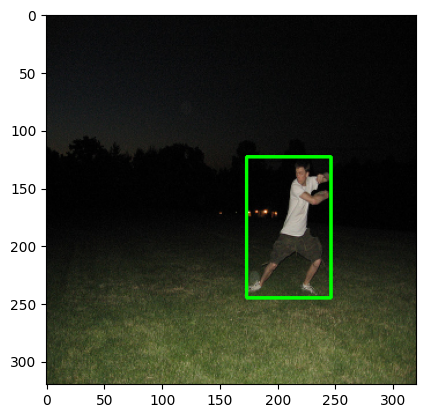

In [ ]:
ann_text_processed = []
img = transforms.ToTensor()(Image.open("/home/mka219/sfuhome/T2- A1/A1/workspace/data/train/images/00005.jpg"))
org_width = img.shape[2]
org_height = img.shape[1]
resize_t = transforms.Resize((320, 320))
img = resize_t(img)
img = img*255
img = np.transpose(img.numpy(), (1,2,0)).astype(np.uint8)
img = np.ascontiguousarray(img, dtype=np.uint8)

ann_text = open("/home/mka219/sfuhome/T2- A1/A1/workspace/data/train/annotations/00005.txt").readlines()
ann_box = np.zeros([540,4], np.float32) #bounding boxes
ann_confidence = np.zeros([540,4], np.float32)
for line in ann_text:
    ann_text_processed.append( [float(i) for i in line.rstrip().split(' ')] )

for line in ann_text_processed:
    print(line)
    class_id = line[0]
    
    #print("gx, gy, gw, gh", gx, "  ", gy, "  ", gw, "  ", gh, "  ")
    start_point = ( int( (line[1]/org_width)*320 ), int( (line[2]/org_height)*320 ) )
    end_point = ( int( ( line[1]/org_width+line[3]/org_width )*320 ), int( ( line[2]/org_height+line[4]/org_height )*320 ) )

    thickness = 2
    cv2.rectangle(img, start_point, end_point, (0,255,0), thickness)
    #count = count+1
    #if count==4:
    #    break
plt.imshow(img)

In [ ]:
boxs_default[0]

array([0.05, 0.05, 0.1 , 0.1 , 0.  , 0.  , 0.1 , 0.1 ])

In [ ]:
np.min(boxs_default)

0.0